# 連続空間での最適化

ここまでのチュートリアルでは、特徴量空間を離散化してベイズ最適化を実行してきました。
PHYSBOは連続量のまま最適化することもできます。

PHYSBOは連続空間で獲得関数を最大化するためのライブラリとして、[ODAT-SE](https://github.com/issp-center-dev/ODAT-SE)を使用します。
`pip` を用いてインストール可能です。

``` bash
python3 -m pip install odatse
```

## 基本的な使い方

まずは必要なモジュールをインポートします。

In [1]:
import numpy as np
import physbo
import matplotlib.pyplot as plt

最適化したい関数 `simulator` について、離散版では候補点の番号 `action` を入力として受け取りましたが、連続版では座標 `x` を直接入力として受け取ります。
`x` は $N\times D$ の配列で、$N$ は計算するデータの数、$D$ は特徴量の次元数です。

In [2]:
def simulator(x):
    return -np.sum(x**2, axis=1)

特徴量空間の下限と上限をそれぞれ `min_X` と `max_X` で指定します。

In [3]:
min_X = [-2.0, -2.0]
max_X = [2.0, 2.0]

連続空間版の `Policy` クラスは `physbo.search.range.Policy` です。
コンストラクタには `min_X` と `max_X` を指定します。
また、離散空間版と同様に `mpi4py.MPI.Comm` を `comm` として渡すことで並列実行が可能です。
`set_seed` メソッドを用いて乱数のシードを設定することもできます。

In [4]:
seed = 31415
policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)

一度 `Policy` クラスを作成してからは、離散空間版と同様の流れで最適化を実行できます。
まずは、サロゲートモデルを学習するための初期訓練データを作成するために、 `random_search` を実行します。

In [5]:
policy.random_search(max_num_probes=10, simulator=simulator)

0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

次に、 `bayes_search` でベイズ最適化を実行します。

In [6]:
res = policy.bayes_search(max_num_probes=10, simulator=simulator, score="EI")

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 14.586042968393606
50 -th epoch marginal likelihood 14.234874815492592
100 -th epoch marginal likelihood 14.063504009485214
150 -th epoch marginal likelihood 13.916750623078872
200 -th epoch marginal likelihood 13.772691286779512
250 -th epoch marginal likelihood 13.633003306706115
300 -th epoch marginal likelihood 13.49920085405347
350 -th epoch marginal likelihood 13.371932369305052
400 -th epoch marginal likelihood 13.251396114620242
450 -th epoch marginal likelihood 13.13755169992651
500 -th epoch marginal likelihood 13.03022856247339
Done

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 14.481946296808848
50 -th epoch marginal likelihood 14.226839207527519
100 -th epoch marginal likelihood 14.032412353874676
150 -th epoch marginal likelihood 13.86424527985262
200 -th epoch marginal 

各ステップにおけるODAT-SEの最適化過程が標準出力に出されています。ODAT-SEはPHYSBOとは逆に最小化を行うライブラリなので、獲得関数に-1をかけて最小化問題としている点に注意してください。

`bayes_search` 関数の返り値 `res` にはベイズ最適化の過程が保存されています。 `export_sequence_best_fx` メソッドを用いることで、各ステップでの最適化結果を取得できます。

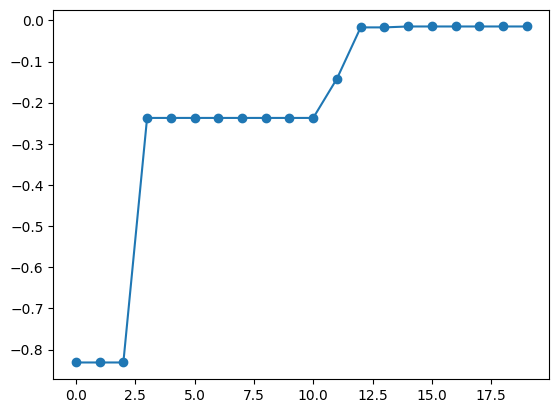

In [7]:
best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")

## 獲得関数の最適化

獲得関数の最適化にはODAT-SEを使用します。デフォルトではグリッドサーチを用いて最適化を行います。最適化手法は `alg_name` キーワードで指定でき、

- "exchange": レプリカ交換モンテカルロ法
- "pamc": ポピュレーションアニーリングモンテカルロ法
- "minsearch": Nelder-Mead法
- "mapper": グリッドサーチ
- "bayes": ベイズ最適化

が選べます。例えばレプリカ交換モンテカルロ法を用いた最適化を行う場合は、

0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

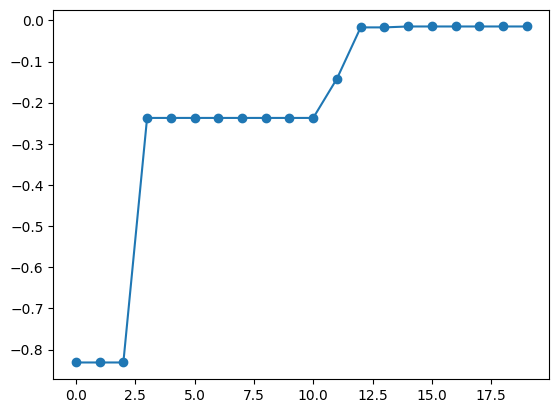

In [8]:
policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)
policy.random_search(max_num_probes=10, simulator=simulator)
res = policy.bayes_search(max_num_probes=10, simulator=simulator, alg_name="exchange", score="EI")

best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")

たとえばレプリカ交換モンテカルロ法で使われる温度など、各手法のハイパーパラメータはデフォルトのものが使用されます。これらを変更する場合には、 `bayes_search` 関数に辞書型の変数 `alg_dict` を渡します。これは[ODAT-SEの入力ファイル](https://issp-center-dev.github.io/ODAT-SE/manual/main/ja/input.html)における、 `[algorithm]` セクションとして用いられます。

`physbo.search.odatse.default_alg_dict` 関数を用いて、それぞれの最適化手法に対するPHYSBOでのデフォルトパラメータを取得できます。これを修正するのが最も簡単です。
例えばレプリカ交換モンテカルロ法で、最低温度 `Tmin` をデフォルト値の半分にしたい場合は、

0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

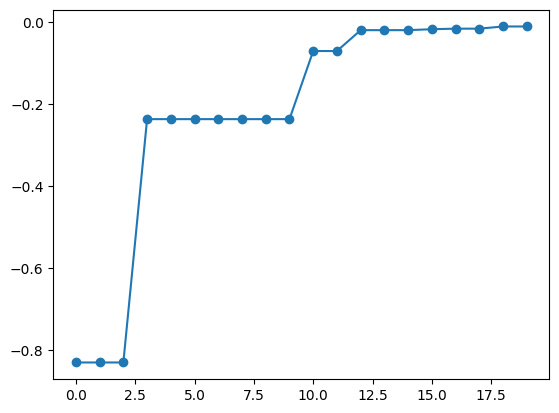

In [9]:
alg_dict = physbo.search.odatse.default_alg_dict(min_X, max_X, "exchange")
alg_dict["exchange"]["Tmin"] *= 0.5

policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)

policy.random_search(max_num_probes=10, simulator=simulator)
res = policy.bayes_search(max_num_probes=10, simulator=simulator, score="EI", alg_dict=alg_dict)

best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")